<a href="https://colab.research.google.com/github/For-Chance/CourseOfConstructionInformation/blob/master/FinalTask/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Task

In [248]:
%%capture
!apt install subversion
!svn checkout https://github.com/For-Chance/CourseOfConstructionInformation/trunk/FinalTask/data

In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [250]:
trans = pd.read_csv('./data/transactions.csv')
agency = pd.read_csv('./data/agency.csv')
agents = pd.read_csv('./data/agents.csv')

# Merge tables
df = pd.merge(agency, agents)
df = pd.merge(df, trans)

# Drop meaningless column
df = df.drop(['Name','FirstName','LastName'], axis = 1)

# Rename
df.rename(columns = {
    'X1 transaction date': 'X1',
    'X2 house age': 'X2',
    'X3 distance to the nearest MRT station': 'X3',
    'X4 number of convenience stores': 'X4',
    'X5 latitude': 'X5',
    'X6 longitude': 'X6',
    'Y house price of unit area':'Y'}, inplace=True)

source = df.copy()
df.head()

,AgencyId,AgentId,X1,X2,X3,X4,X5,X6,Y
0,0,0,2012.667,20.4,2469.64500,4,24.96108,121.51046,23.8
1,0,0,2013.167,16.2,289.32480,5,24.98203,121.54348,46.2
2,0,0,2012.667,29.4,4510.35900,1,24.94925,121.49542,13.2
3,0,0,2012.833,31.7,1160.63200,0,24.94968,121.53009,13.7
4,0,0,2013.583,6.6,90.45606,9,24.97433,121.54310,59.0


## Part 2 —— Machine learning
> For this part, your goal is to prepare, train and test the Machine Learning model that can estimate the 
house price of unit area. 

### Task 5 —— 10 points
> Select the features and labels (X and y) from your dataset. Make sure that your selection is reasonable. 
Split the data into two datasets (training and testing).

#### Add Feature

According to X5-latitude and X6-longitude, the figure below shows the relationship between location and house price.

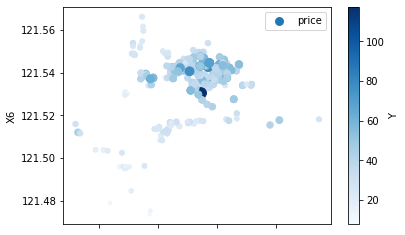

In [251]:
df.plot(kind='scatter',x='X5',y='X6',alpha=1,s=df['Y'], c='Y', label='price', colormap='Blues',colorbar=True)
plt.legend();

> As we can see, house price is definitely not decided independently by latitude or longitude, but the spatial location. Besides, the figure shows that the farther away from the downtown, house price more expensive. Therefore, we according to the following formula downtown location.
$$
center_x = \frac{∑ x_i P }{∑ P} \\
center_y = \frac{∑ y_i P }{∑ P}
$$
where $(x_i,y_i)$ represents the location of one house, and $P$ is corresponding house price.

In [252]:
# define downtown location
# and define the distance of each house with downtown as X7
center_x = sum(df['X5'] * df['Y']) / df['Y'].sum()
center_y = sum(df['X6'] * df['Y']) / df['Y'].sum()
df['X7'] = ((df['X5']-center_x)**2+(df['X6']-center_y)**2)**0.5 * 100000    # A unit of longitude is about 100 km
df = df.drop(columns=['X5', 'X6'])
print(f'downtown loation is ({center_x:.4f}, {center_y:.4f})')
df.head()

downtown loation is (24.9715, 121.5362)


,AgencyId,AgentId,X1,X2,X3,X4,Y,X7
0,0,0,2012.667,20.4,2469.64500,4,23.8,2778.053397
1,0,0,2013.167,16.2,289.32480,5,46.2,1282.246917
2,0,0,2012.667,29.4,4510.35900,1,13.2,4646.003385
3,0,0,2012.833,31.7,1160.63200,0,13.7,2262.259333
4,0,0,2013.583,6.6,90.45606,9,59.0,744.690602


#### Select Features

In [253]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['AgencyId','AgentId']) 
df.head()

,X1,X2,X3,X4,Y,X7,AgencyId_0,AgencyId_1,AgencyId_2,AgentId_0,AgentId_1,AgentId_2,AgentId_3,AgentId_4,AgentId_5
0,2012.667,20.4,2469.64500,4,23.8,2778.053397,1,0,0,1,0,0,0,0,0
1,2013.167,16.2,289.32480,5,46.2,1282.246917,1,0,0,1,0,0,0,0,0
2,2012.667,29.4,4510.35900,1,13.2,4646.003385,1,0,0,1,0,0,0,0,0
3,2012.833,31.7,1160.63200,0,13.7,2262.259333,1,0,0,1,0,0,0,0,0
4,2013.583,6.6,90.45606,9,59.0,744.690602,1,0,0,1,0,0,0,0,0


In [254]:
# Correlation Matrix
import seaborn as sns
corr = df.corr()
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Analyse")\
    .set_precision(2)\
    .set_table_styles(magnify())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`


,X1,X2,X3,X4,Y,X7,AgencyId_0,AgencyId_1,AgencyId_2,AgentId_0,AgentId_1,AgentId_2,AgentId_3,AgentId_4,AgentId_5
X1,1.00,0.02,0.06,0.01,0.09,0.06,0.01,-0.01,0.01,0.01,0.02,0.06,-0.05,-0.01,-0.04
X2,0.02,1.00,0.03,0.05,-0.21,-0.05,-0.03,-0.02,0.04,-0.03,-0.01,-0.03,0.01,0.07,-0.01
X3,0.06,0.03,1.00,-0.60,-0.67,0.96,0.03,-0.01,-0.01,0.03,0.01,0.07,-0.03,-0.03,-0.06
X4,0.01,0.05,-0.60,1.00,0.57,-0.54,-0.07,-0.02,0.07,-0.07,0.05,-0.04,0.03,0.04,-0.02
Y,0.09,-0.21,-0.67,0.57,1.00,-0.64,-0.05,0.00,0.03,-0.05,0.02,-0.07,-0.00,0.01,0.10
X7,0.06,-0.05,0.96,-0.54,-0.64,1.00,0.05,-0.01,-0.02,0.05,0.01,0.08,-0.04,-0.04,-0.07
AgencyId_0,0.01,-0.03,0.03,-0.07,-0.05,0.05,1.00,-0.35,-0.24,1.00,-0.15,-0.17,-0.17,-0.15,-0.11
AgencyId_1,-0.01,-0.02,-0.01,-0.02,0.00,-0.01,-0.35,1.00,-0.82,-0.35,-0.51,0.48,0.49,-0.52,0.32
AgencyId_2,0.01,0.04,-0.01,0.07,0.03,-0.02,-0.24,-0.82,1.00,-0.24,0.62,-0.39,-0.41,0.63,-0.26
AgentId_0,0.01,-0.03,0.03,-0.07,-0.05,0.05,1.00,-0.35,-0.24,1.00,-0.15,-0.17,-0.17,-0.15,-0.11


According to the column of Y, X3, X4, X5, X6 and X7 have certain relevance with house price. Because X7 combines the X5 and X6, we choose X3, X4, X7 as appropriate features. 

In [255]:
df = df[['X3','X4','X7','Y']]
df.head()

,X3,X4,X7,Y
0,2469.64500,4,2778.053397,23.8
1,289.32480,5,1282.246917,46.2
2,4510.35900,1,4646.003385,13.2
3,1160.63200,0,2262.259333,13.7
4,90.45606,9,744.690602,59.0


#### Remove Outliers

df shape: (414, 4)


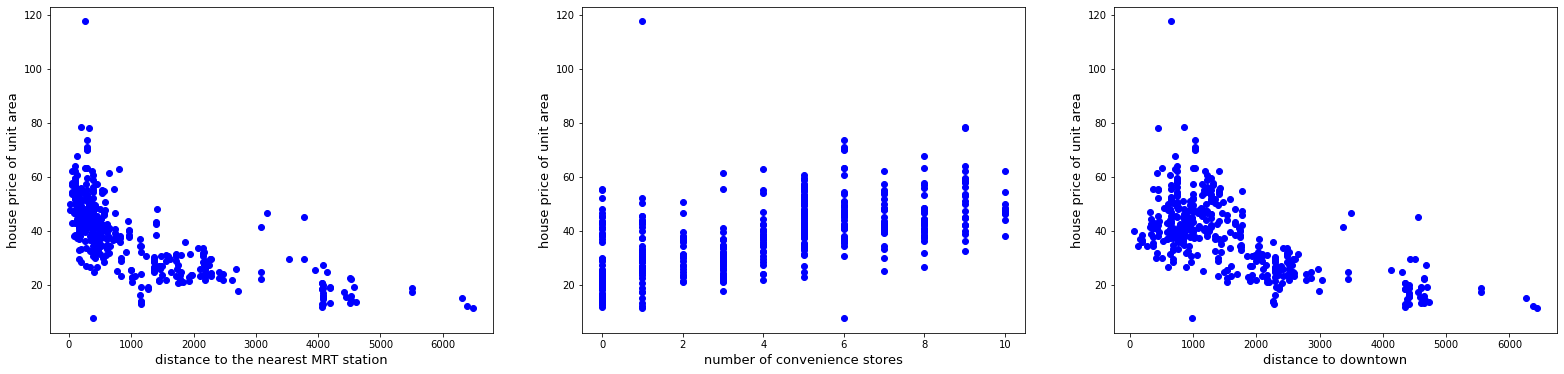

In [256]:
# Draw a scatter diagram to check the outliers
def plotScatter():
  """dfhaisf"""
  plt.figure(figsize=(27, 6))

  plt.subplot(1, 3, 1)
  plt.scatter(x=df.X3, y=df.Y, color='b')
  plt.xlabel("distance to the nearest MRT station", fontsize=13)
  plt.ylabel("house price of unit area", fontsize=13)

  plt.subplot(1, 3, 2)
  plt.scatter(x=df.X4, y=df.Y, color='b')
  plt.xlabel("number of convenience stores", fontsize=13)
  plt.ylabel("house price of unit area", fontsize=13)

  plt.subplot(1, 3, 3)
  plt.scatter(x=df.X7, y=df.Y, color='b')
  plt.xlabel("distance to downtown", fontsize=13)
  plt.ylabel("house price of unit area", fontsize=13)

print(f'df shape: {df.shape}')
plotScatter()


Assumes that the data meet normal distribution, we can use 3 $\sigma$ principle to remove outliers.

df shape: (408, 4)


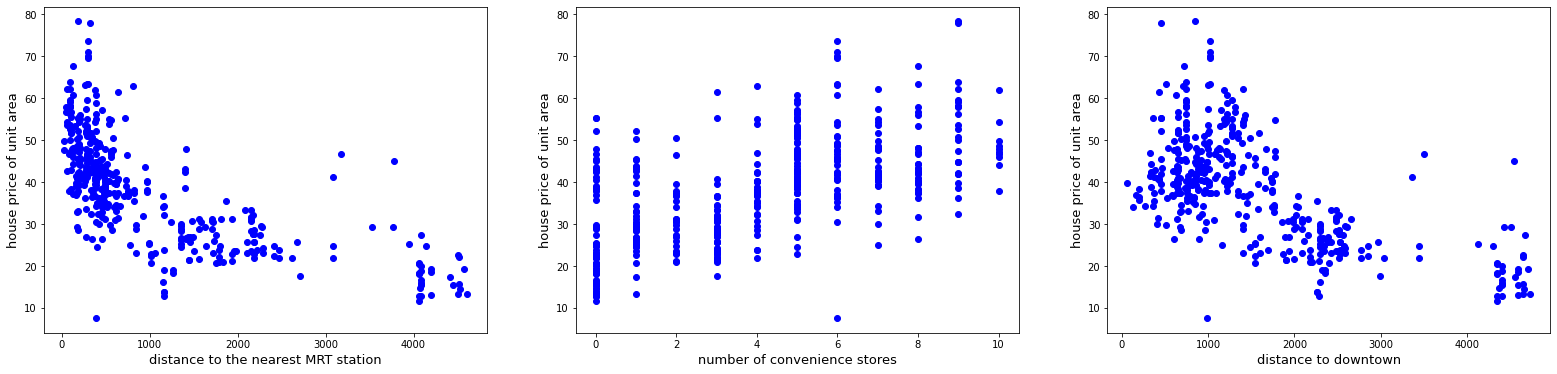

In [257]:
# Remove outliers
mean, std = df.mean(), df.std()
cut_off = std * 3
lower, upper = mean - cut_off, mean + cut_off

df = df[(df['X3'] > lower['X3']) & (df['X3'] < upper['X3'])]
df = df[(df['X4'] > lower['X4']) & (df['X4'] < upper['X4'])]
df = df[(df['X7'] > lower['X7']) & (df['X7'] < upper['X7'])]
df = df[(df['Y'] > lower['Y']) & (df['Y'] < upper['Y'])]

print(f'df shape: {df.shape}')
plotScatter()

#### Adjust Object Variable

In [258]:
from scipy.stats import norm
from scipy import stats

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

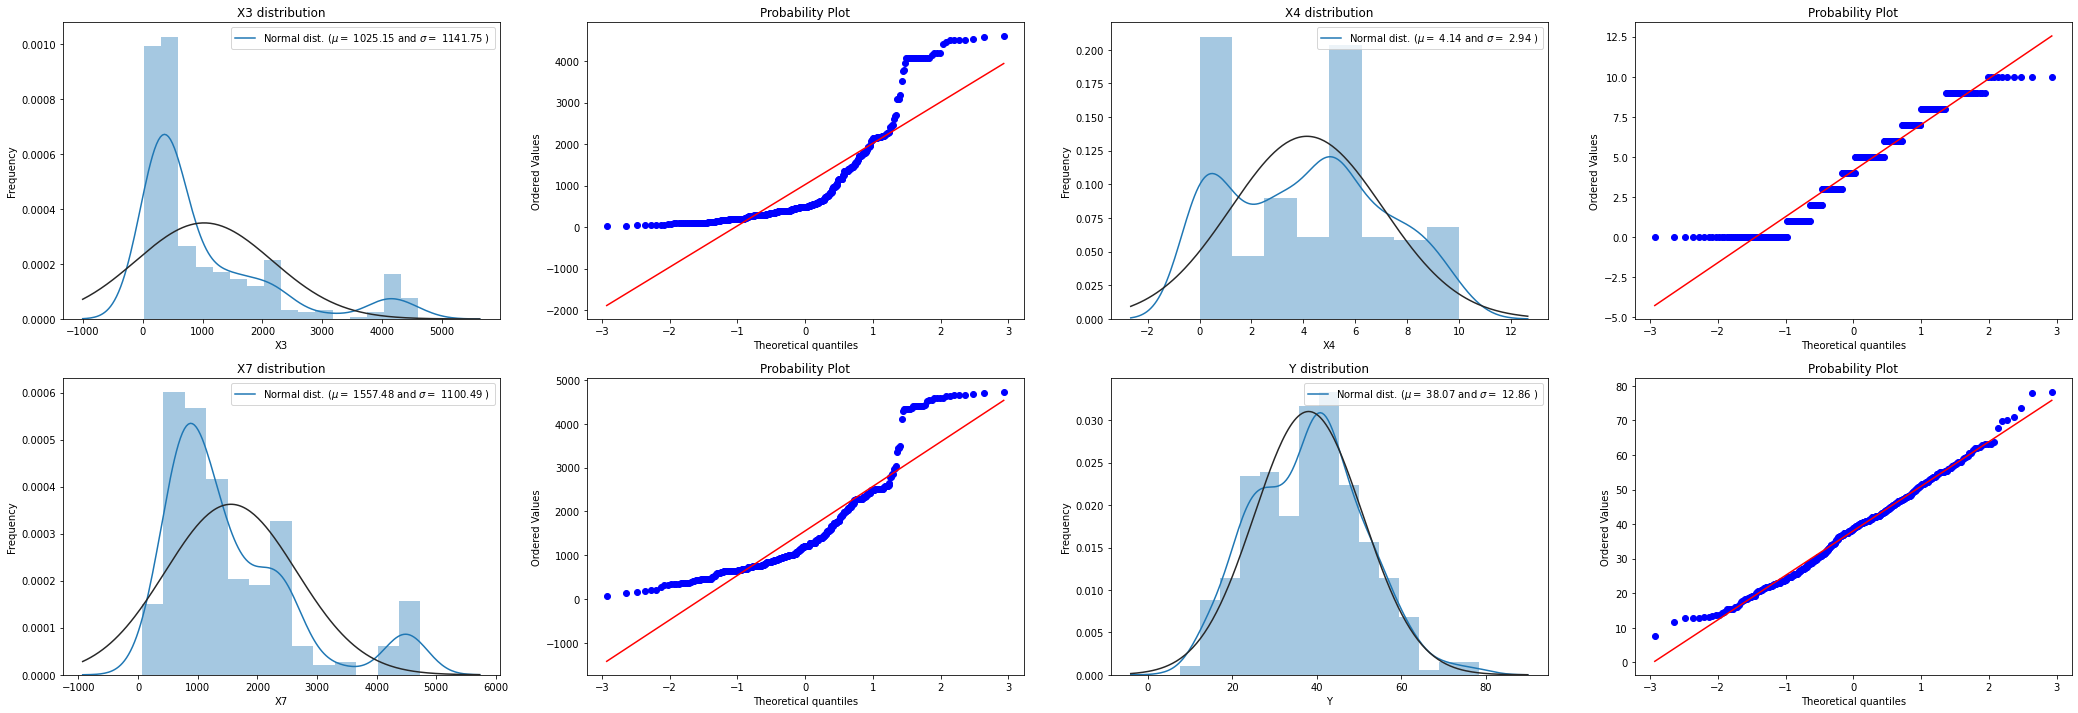

In [259]:
def plt_distribution(data):
    """Plot the distribution"""
    plt.figure(figsize=(36,12))

    cnt = 0
    for col in data:
      plt.subplot(2,4,2*cnt+1)
      sns.distplot(data[col] , fit=norm);

      (mu, sigma) = norm.fit(data[col])
      # print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

      plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                  loc='best')
      plt.ylabel('Frequency')
      plt.title(f'{col} distribution')

      plt.subplot(2,4,2*cnt+2)
      stats.probplot(data[col], plot=plt)
      cnt += 1
plt_distribution(df)

As we can see, X3 and X7 don't meet normalization. So we need to adjust them.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

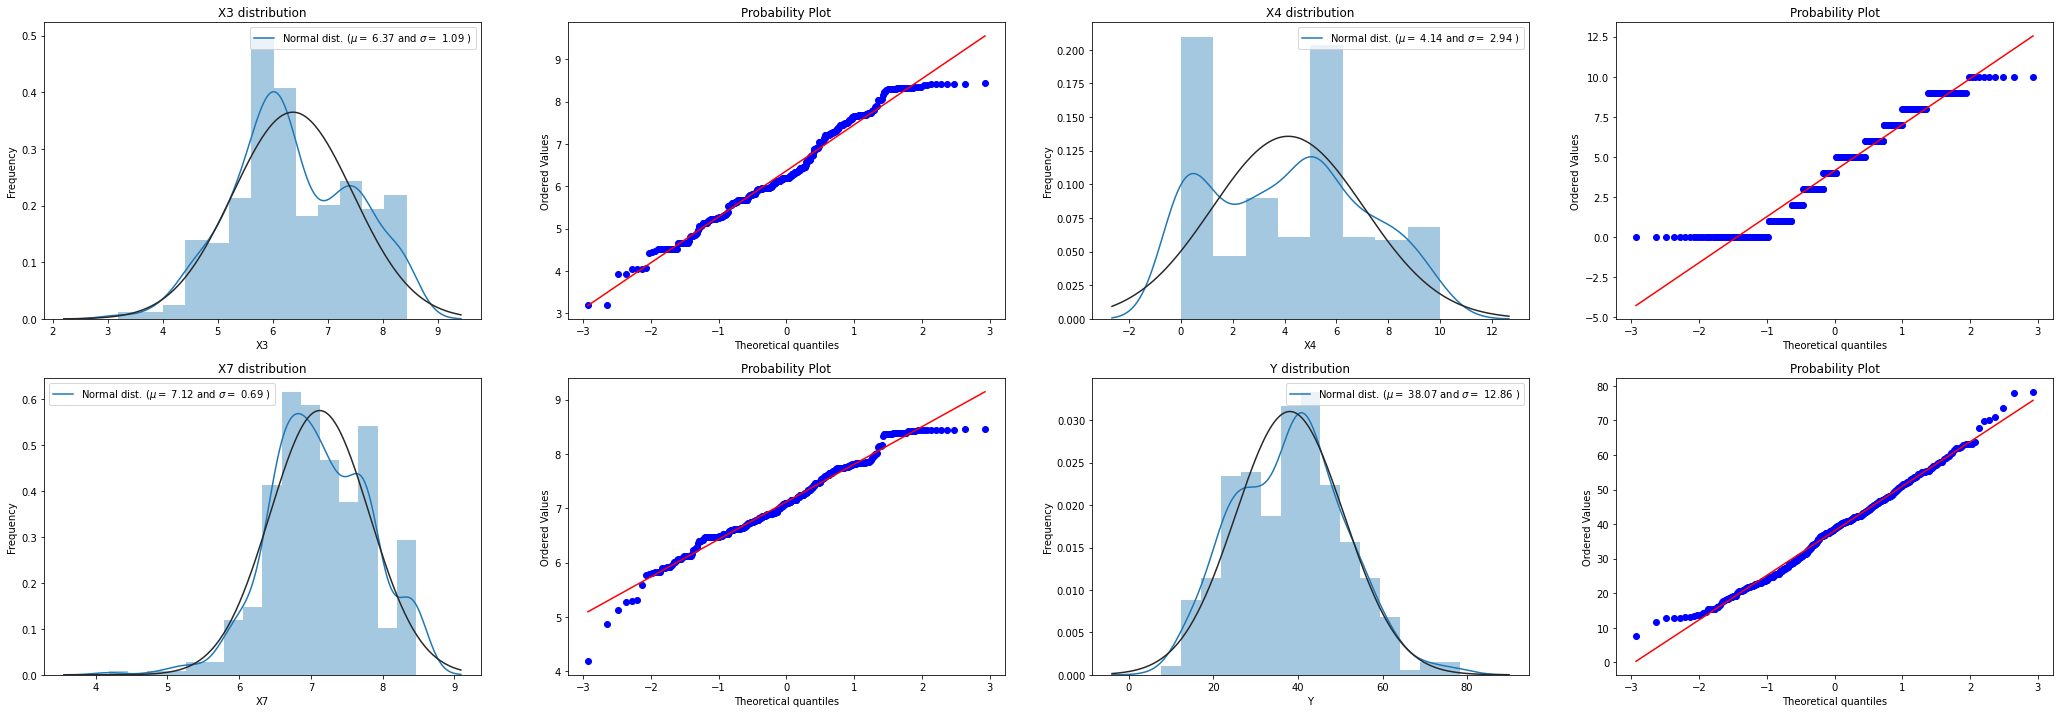

In [260]:
df['X3'] = np.log1p(df['X3'])
df['X7'] = np.log1p(df['X7'])
df.head()
plt_distribution(df)

> 

### Task 6 —— 10 points
> Prepare the Machine Learning model, then train and test this model. For this task, you should provide your code in Python as well as the accuracy of the model. As an accuracy, you should report Mean Absolute Error and Mean Absolute Percentage Error. You may also report other metrics (R2, SMAPE, MSE) but this is not necessary.

In [261]:
df.head()

,X3,X4,X7,Y
0,7.812235,4,7.929866,23.8
1,5.671000,5,7.157149,46.2
2,8.414354,1,8.443978,13.2
3,7.057581,0,7.724561,13.7
4,4.515859,9,6.614311,59.0


In [262]:
from sklearn.model_selection import train_test_split

X = df[['X3','X4','X7']].copy()
y = df['Y']

# df = source
# # One-Hot Encoding
# df = pd.get_dummies(df, columns=['AgencyId','AgentId']) 
# df.head()
# X = df.drop(columns=['Y'])
# y = df['Y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1)

print('X train shape:', X_train.shape)
print('X test shape:', X_test.shape)
print('y train shape:', y_train.shape)
print('y test shape:', y_test.shape)
X.head()

X train shape: (306, 3)
X test shape: (102, 3)
y train shape: (306,)
y test shape: (102,)


,X3,X4,X7
0,7.812235,4,7.929866
1,5.671000,5,7.157149
2,8.414354,1,8.443978
3,7.057581,0,7.724561
4,4.515859,9,6.614311


In [263]:
# normalize
X['X3'] = (X['X3']-X['X3'].min())/(X['X3'].max()-X['X3'].min())
X['X4'] = (X['X4']-X['X4'].min())/(X['X4'].max()-X['X4'].min())
X['X7'] = (X['X7']-X['X7'].min())/(X['X7'].max()-X['X7'].min())
X.head()

,X3,X4,X7
0,0.881130,0.4,0.875433
1,0.472607,0.5,0.694875
2,0.996008,0.1,0.995563
3,0.737151,0.0,0.827460
4,0.252219,0.9,0.568033


In [264]:
def print_mae_train(model, X, y):
    pred = model.predict(X)
    error = np.mean(np.abs(y-pred))
    print("MAE error for train set: {:.1f}".format(error))
def print_mae_test(model, X, y):
    pred = model.predict(X)
    error = np.mean(np.abs(y-pred))
    print("MAE error for test set: {:.1f}".format(error))

def print_mape_train(model, X, y):
    pred = model.predict(X)
    error = np.mean(100 * np.abs((y-pred) / y))
    print("MAPE error for train set: {:.1f}%".format(error))
def print_mape_test(model, X, y):
    pred = model.predict(X)
    error = np.mean(100 * np.abs((y-pred) / y))
    print("MAPE error for test set: {:.1f}%".format(error))

def get_mape(model, X, y):
    pred = model.predict(X)
    return np.mean(100 * np.abs((y-pred) / y))

def show_result(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
  print_mae_train(model, X_train, y_train)
  print_mae_test(model, X_test, y_test)
  print_mape_train(model, X_train, y_train)
  print_mape_test(model, X_test, y_test)
  try:
    print("Train set accuracy:", model.score(X_train, y_train))
    print("Test set accuracy:", model.score(X_test, y_test))
  except:
    pass

In [265]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

show_result(model)

MAE error for train set: 6.5
MAE error for test set: 5.3
MAPE error for train set: 18.4%
MAPE error for test set: 19.4%
Train set accuracy: 0.5691404335177856
Test set accuracy: 0.5866498061740215


In [266]:
from sklearn.ensemble import RandomForestRegressor
mapes_train = []
mapes_test = []

for i in range(1, 40):
  model = RandomForestRegressor(min_samples_leaf=i)
  model.fit(X_train,y_train)
  train_mape = get_mape(model, X_train, y_train)
  mapes_train.append(train_mape)
  test_mape = get_mape(model, X_test, y_test)
  mapes_test.append(test_mape)

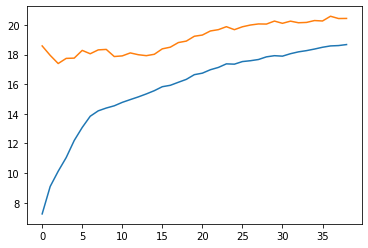

In [267]:
plt.figure()
plt.plot(mapes_train)
plt.plot(mapes_test)

## Auto Machine Learning

In [273]:
%%capture
!pip install boto3 botocore awscli aiobotocore --ignore-installed
!pip install autogluon

In [274]:
from autogluon.tabular import TabularDataset, TabularPredictor

ImportError: ignored

In [271]:
# df = source.copy()
# df = df[['X2', 'X3', 'X4', 'X7', 'Y']]
# df = np.log1p(df)

from sklearn.utils import shuffle
df = shuffle(df).reset_index(drop=True)
df.head()

split_point = int(len(df)*0.75)
train_data, test_data = df[:split_point], df[split_point:]

print('train data shape:', train_data.shape)
print('test data shape:', test_data.shape)

train data shape: (306, 4)
test data shape: (102, 4)


In [272]:

train_data = TabularDataset(train_data)
test_data = TabularDataset(test_data)
X_train = train_data.drop(columns=['Y'])
y_train = train_data['Y']
X_test = test_data.drop(columns=['Y'])
y_test = test_data['Y']

ImportError: ignored

In [ ]:
# fit model
save_path = 'best_model'
model = TabularPredictor(label='Y', path=save_path).fit(
  train_data
)

Beginning AutoGluon training ...
AutoGluon will save models to "best_model/"
AutoGluon Version:  0.4.2
Python Version:     3.7.13
Operating System:   Linux
Train Data Rows:    306
Train Data Columns: 4
Label Column: Y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (117.5, 11.6, 38.38431, 13.97699)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11908.27 MB
	Train Data (Original)  Memory Usage: 0.01 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the f

In [ ]:
model = TabularPredictor.load(save_path)

In [ ]:
model.evaluate(test_data)

Evaluation: root_mean_squared_error on test data: -6.289455035572978
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -6.289455035572978,
    "mean_squared_error": -39.557244644494276,
    "mean_absolute_error": -4.504164437686695,
    "r2": 0.7120512114091586,
    "pearsonr": 0.8478098747436937,
    "median_absolute_error": -3.333255004882812
}


{'mean_absolute_error': -4.504164437686695,
 'mean_squared_error': -39.557244644494276,
 'median_absolute_error': -3.333255004882812,
 'pearsonr': 0.8478098747436937,
 'r2': 0.7120512114091586,
 'root_mean_squared_error': -6.289455035572978}

In [ ]:
# def print_mae_train(model, X, y):
#     pred = model.predict(X)
#     error = np.mean(np.abs(np.expm1(y)-np.expm1(pred)))
#     print("MAE error for train set: {:.1f}".format(error))
# def print_mae_test(model, X, y):
#     pred = model.predict(X)
#     error = np.mean(np.abs(np.expm1(y)-np.expm1(pred)))
#     print("MAE error for test set: {:.1f}".format(error))

# def print_mape_train(model, X, y):
#     pred = model.predict(X)
#     error = np.mean(100 * np.abs(np.abs(np.expm1(y)-np.expm1(pred))) / np.expm1(y))
#     print("MAPE error for train set: {:.1f}%".format(error))
# def print_mape_test(model, X, y):
#     pred = model.predict(X)
#     error = np.mean(100 * np.abs(np.abs(np.expm1(y)-np.expm1(pred))) / np.expm1(y))
#     print("MAPE error for test set: {:.1f}%".format(error))

# def show_result(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
#   print_mae_train(model, X_train, y_train)
#   print_mae_test(model, X_test, y_test)
#   print_mape_train(model, X_train, y_train)
#   print_mape_test(model, X_test, y_test)
#   try:
#     print("Train set accuracy:", model.score(X_train, y_train))
#     print("Test set accuracy:", model.score(X_test, y_test))
#   except:
#     pass

show_result(model, X_train=train_data.drop(columns=['Y']), y_train=train_data['Y'], X_test=test_data.drop(columns=['Y']), y_test=test_data['Y'])

MAE error for train set: 3.3
MAE error for test set: 4.5
MAPE error for train set: 9.4%
MAPE error for test set: 16.1%
